In [1]:
import os.path
import re
import pprint as pp
import yaml
import pathlib

import bson
import seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages
import scipy.signal
from pymongo import MongoClient
from gridfs import GridFS

import eim

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
song_label = 'S002'
song_title_for_filename = 'hallelujah'
critical_time = 59.5

## Setup connection to the database

In [3]:
creds_path = pathlib.Path('/home/paperspace/eim-creds.yml')
with open(creds_path, 'r') as stream:
    try:
        creds = yaml.load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [4]:
client = MongoClient()
client = MongoClient(host='eim-data.musicsensorsemotion.com', 
                     port=27017, 
                     username=creds['username'], 
                     password=creds['password'], 
                     authSource='admin', 
                     ssl=True)
db = client.eim

In [5]:
trials = db.trials
media = db.media
signals = db.signals

In [6]:
song_media = media.find_one({'label': song_label})
pp.pprint(song_media)

{'_id': ObjectId('538b777e2212e1eda2ff48bf'),
 'artist': 'Jeff Buckley',
 'bpm': None,
 'comments': None,
 'emotion_tags': [ObjectId('538bd9352212e1eda2ff529a')],
 'excerpt_end_time': 410.43,
 'excerpt_start_time': 300.27,
 'file': ObjectId('538b8b6a2bfb12c72c651e86'),
 'genres': [ObjectId('538bd1e52212e1eda2ff5297')],
 'has_lyrics': True,
 'key': None,
 'label': 'S002',
 'source': None,
 'title': 'Hallelujah',
 'type': 'audio',
 'year': datetime.datetime(1994, 1, 1, 0, 0)}


In [7]:
control_media = media.find_one({'label': 'C002'})
pp.pprint(control_media)

{'_id': ObjectId('56ccaaa8d4c6ac453fb18ec7'),
 'artist': None,
 'bpm': None,
 'comments': '0m30s of pink noise used as a control sound in several '
             'experiments',
 'emotion_tags': [],
 'excerpt_end_time': 0.0,
 'excerpt_start_time': 30.015,
 'file': ObjectId('56cca64ed4c6ac453fb189cc'),
 'genres': [],
 'has_lyrics': False,
 'key': None,
 'label': 'C002',
 'source': None,
 'title': 'Pink Noise',
 'type': 'audio',
 'year': None}


In [8]:
song_media_id, control_media_id = song_media['_id'], control_media['_id']
song_media_id, control_media_id

(ObjectId('538b777e2212e1eda2ff48bf'), ObjectId('56ccaaa8d4c6ac453fb18ec7'))

In [9]:
no_reaction_ids = np.concatenate((pd.read_csv('./TW_S002_NO.csv').id.values,
                                  pd.read_csv('./DUBNYC_S002_NO.csv').id.values))
reaction_ids = np.concatenate((pd.read_csv('./TW_S002_YES.csv').id.values,
                               pd.read_csv('./DUBNYC_S002_YES.csv').id.values))
bastard_ids = np.concatenate((pd.read_csv('./TW_S002_BS.csv').id.values,
                              pd.read_csv('./DUBNYC_S002_BS.csv').id.values))

In [10]:
no_reaction_ids = np.delete(no_reaction_ids, np.argwhere(np.in1d(no_reaction_ids, bastard_ids)))
reaction_ids = np.delete(reaction_ids, np.argwhere(np.in1d(reaction_ids, bastard_ids)))

In [11]:
all_stimulus_signals = []

for i in reaction_ids:
    trial = db.trials.find_one({'_id': bson.ObjectId(i)})
    signal_idx = trial['media'].index(song_media_id)
    signal_id = trial['signals'][signal_idx]
    signal = db.signals.find_one({'_id': signal_id})
    all_stimulus_signals.append((signal, True))

for i in no_reaction_ids:
    trial = db.trials.find_one({'_id': bson.ObjectId(i)})
    signal_idx = trial['media'].index(song_media_id)
    signal_id = trial['signals'][signal_idx]
    signal = db.signals.find_one({'_id': signal_id})
    all_stimulus_signals.append((signal, False))

## Find all trials signals that used target stimulus

Save those `trials` and `signals` with better than 90% quality.

In [12]:
# all_stimulus_signals = signals.find({'label': song_label})

# Get all trials that have a good (> 0.9) quality score for this stimulus
good_stimulus_trials_and_signals = []
for signal, reaction in all_stimulus_signals:
    try:
        if 'derived_eda_data_file' not in signal.keys():
            continue
        data_file_id = signal['derived_eda_data_file']
        data_file = db.signals.files.find_one({'_id': data_file_id})
        if 'metadata' in data_file.keys():
            if 'quality' in data_file['metadata'].keys():
                quality = data_file['metadata']['quality']
                if 'trial' in signal.keys() and signal['trial'] is not None:
                    instance_dict = {
                        'trial': signal['trial'],
                        'signal': signal,
                        'data_file': data_file,
                        'quality': quality,
                        'reaction': reaction
                    }
                    good_stimulus_trials_and_signals.append(instance_dict)
    except:
        pass

Creater a helper function to add a visual indication of the "reaction range".

In [13]:
def add_reaction_indicator(target_time, lead_in, lead_out):    
    plt.axvline(target_time, color='k', linestyle='dashed', linewidth=1, alpha=0.5)
    ax = plt.gca()
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    left_rectangle = patches.Rectangle((xlims[0], ylims[0]), target_time - lead_in - xlims[0], ylims[1] - ylims[0])
    right_rectangle = patches.Rectangle((target_time + 5., ylims[0]), xlims[1] - (target_time + lead_out), ylims[1] - ylims[0])
    left_rectangle.set_alpha(0.2)
    right_rectangle.set_alpha(0.2)
    ax.add_patch(left_rectangle)
    ax.add_patch(right_rectangle)

## "Reaction finder" helper function

In [14]:
def reaction_present(timestamps, eda, stimulus_time, lead_in, lead_out, height, distance, prominence, width, plot=False):
    
    # Detrend EDA signal
    eda_detrended = scipy.signal.detrend(eda)
    
    # Find peaks in EDA signal
    fs = 1. / np.mean(scipy.diff(timestamps))
    peak_indices, _ = scipy.signal.find_peaks(eda_detrended, height=height, distance=distance, prominence=prominence, width=width)
    peak_timestamps = peak_indices / fs
    
    peaks_in_window = peak_timestamps[(peak_timestamps >= stimulus_time - lead_in) & (peak_timestamps <= stimulus_time + lead_out)]
    
    if plot:
        fig = plt.figure(figsize=(16, 8))
        plt.plot(df.adjusted_time, df.phasic_data)
        plt.scatter(df.adjusted_time[peak_indices], df.phasic_data[peak_indices], c='r', marker='x')
        add_reaction_indicator(hallelujah_time, lead_in, lead_out)
        plt.title('find_peaks with minimum height = None, minimum distance = 1s, minimum prominence = 0.2, and minimum width = 0.9s');
    
    return len(peaks_in_window) > 0

In [15]:
def indicators_from_categories(dataframe, prefix=''):
    """Converts a DataFrame of category columns to indicator columns

    For instance, given a DataFrame that looks something like the following:

    var1 | var2 | var3
    ------------------
    foo  | bar  |
    foo  | bar  | baz
    baz  |      |

    This function returns the following:

    foo | bar | baz
    ---------------
    1   | 0   | 0
    1   | 1   | 1
    0   | 0   | 1

    >>> df = pd.DataFrame(
    ...     data={
    ...         'var1': ['foo','foo','baz'],
    ...         'var2': ['bar', 'bar', None],
    ...         'var3': [None, 'baz', None]
    ...     }
    ... )
    >>> indicated = indicators_from_categories(df, '')
    >>> np.testing.assert_equal(indicated.foo, np.array([1, 1, 0]))
    >>> np.testing.assert_equal(indicated.bar, np.array([1, 1, 0]))
    >>> np.testing.assert_equal(indicated.baz, np.array([0, 1, 1]))
    """
    old_df = dataframe.copy()
    new_df = dataframe.copy()

    # First, get the unique column names
    var_list = np.array([])
    for column in old_df.columns:
        var_list = np.append(var_list, old_df[column].dropna().unique())
    var_list = [prefix + v for v in set(var_list)]

    # Add these columns
    for var in var_list:
        new_df[var] = pd.Series(np.zeros(new_df.shape[0]), index=old_df.index, dtype=np.int32)

    # Iterate each row and populate new columns
    for ix in old_df.index:
        row = old_df.loc[ix]
        for style in old_df.loc[ix].values:
            new_df.loc[ix, prefix + str(style)] = 1

    return new_df[var_list]

### Process good signals

Check each signal for a reaction, and store the result in the dataframe.

In [17]:
lead_in, lead_out = (1.5, 8.5)

file_system = GridFS(db, collection='signals')

no_reaction_signal_list = []
reaction_signal_list = []

with PdfPages(os.path.join('plots', song_title_for_filename + '_no_reaction_no_bs.pdf')) as no_reaction_pdf:
    with PdfPages(os.path.join('plots', song_title_for_filename + '_reaction_no_bs.pdf')) as reaction_pdf:
        for instance_dict in good_stimulus_trials_and_signals:
            data_file = instance_dict['data_file']
            data = file_system.find_one({'filename': data_file['filename']})
            df = pd.read_csv(data, usecols=['adjusted_time', 'phasic_data'])

            df['phasic_data'] = scipy.signal.detrend(df.phasic_data)

            fs = 1. / np.mean(scipy.diff(df.adjusted_time))

            min_peak_height = None
            min_peak_distance = fs * 1.
            min_peak_prominence = df['phasic_data'].std() * 1.5 # 1.4043483998165829
            min_peak_width = fs * 0.9

#             reaction = reaction_present(df.adjusted_time, df.eda_cleaned, critical_time, lead_in, lead_out, min_peak_height, min_peak_distance, min_peak_prominence, min_peak_width)
            reaction = instance_dict['reaction']

            if reaction:
                plt.plot(df.adjusted_time, df.phasic_data)
                plt.xlabel('Time [seconds]')
                plt.ylabel('Skin conductance (detrended) [$\mu$S]')
                plt.title('Example with reaction ({})'.format(instance_dict['trial']))
                plt.ylim([-2., 2])
                add_reaction_indicator(critical_time, lead_in, lead_out)                
                plt.tight_layout()
                reaction_pdf.savefig()
                plt.close()
                reaction_signal_list.append(df[['adjusted_time', 'phasic_data']])
            else:
                plt.plot(df.adjusted_time, df.phasic_data)
                plt.xlabel('Time [seconds]')
                plt.ylabel('Skin conductance (detrended) [$\mu$S]')
                plt.title('Example without reaction ({})'.format(instance_dict['trial']))
                plt.ylim([-2., 2])
                add_reaction_indicator(critical_time, lead_in, lead_out)                
                plt.tight_layout()
                no_reaction_pdf.savefig()
                plt.close()
                no_reaction_signal_list.append(df[['adjusted_time', 'phasic_data']])

            instance_dict['reaction'] = reaction
            instance_dict['df'] = df

Plot the results of the above processing.

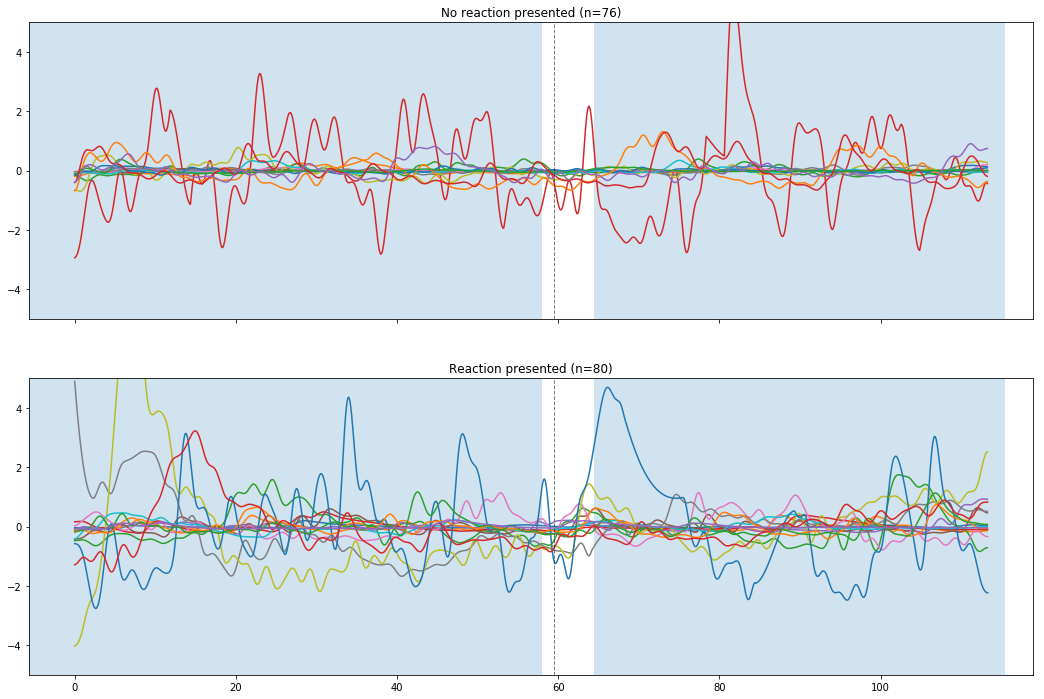

In [18]:
fig, [no_ax, yes_ax] = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(18,12))

for df in no_reaction_signal_list[0:15]:
    no_ax.plot(df.adjusted_time, df.phasic_data)

for df in reaction_signal_list[0:15]:
    yes_ax.plot(df.adjusted_time, df.phasic_data)

no_ax.set_ylim([-5, 5])
    
plt.sca(no_ax)
add_reaction_indicator(critical_time, lead_in, lead_out)
plt.sca(yes_ax)
add_reaction_indicator(critical_time, lead_in, lead_out)

no_ax.set_title('No reaction presented (n={})'.format(len(no_reaction_signal_list)))
yes_ax.set_title('Reaction presented (n={})'.format(len(reaction_signal_list)));

Helper function to pull in associated data for a given `trial`

In [19]:
def associate_trial(trial, eim_db):
    # Copy input
    associated_trial = dict(trial)
    
    # Get associated experiments, media, and signals
#     associated_trial['experiment'] = eim_db.experiments.find_one({"_id": trial['experiment']})
#     associated_trial['media'] = [eim_db.media.find_one({"_id": _id}) for _id in trial['media']]
#     associated_trial['signals'] = [eim_db.signals.find_one({"_id": _id}, {"metadata": 0}) for _id in trial['signals']]
    
    return associated_trial

Helper function to "flatten" a `trial`

In [20]:
def flatten_trial(trial, delimiter='.'):
    out = {}

    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + delimiter)
        elif type(x) is list:
            if len(x) == 0:
                out[name[:-1]] = None
            else:
                i = 0
                for a in x:
                    flatten(a, name + str(i) + delimiter)
                    i += 1
        else:
            out[name[:-1]] = x

    flatten(trial)
    return out

## Collect all trials together, associate related entities, and put them in a DataFrame

In [21]:
def media_index(trial, media_id):
    if media_id in trial['media']:
        return trial['media'].index(media_id)
    else:
        return None

In [22]:
def extract_ratings_data(trial, index, prefix=''):
    all_ratings = trial['answers']['ratings']
    if all_ratings is not None:
        for key in all_ratings.keys():
            if index is not None:
                trial[prefix + key] = all_ratings[key][index]
            else:
                trial[prefix + key] = None
    
    return trial

In [23]:
def remove_bad_keys(trial):
    try:
        trial['metadata'].pop('terminal')
    except:
        pass
    
    try:
        trial['metadata'].pop('session_number')
    except:
        pass
        
    try:
        trial['answers'].pop('most_engaged')
    except:
        pass
        
    try:
        trial['answers'].pop('most_enjoyed')
    except:
        pass
        
    try:
        trial['answers'].pop('ratings')
    except:
        pass
        
    try:
        trial['answers'].pop('emotion_indices')
    except:
        pass
        
    try:
        trial.pop('media')
    except:
        pass
        
    try:
        trial.pop('date')
    except:
        pass
        
    try:
        trial.pop('valid')
    except:
        pass
        
    try:
        trial.pop('random')
    except:
        pass
        
    try:
        trial.pop('experiment')
    except:
        pass
        
    try:
        trial.pop('signals')
    except:
        pass
        
    try:
        trial.pop('timestamps')
    except:
        pass

    return trial

In [24]:
all_trials = pd.DataFrame()
all_trials_n = len(good_stimulus_trials_and_signals)
for n, instance_dict in enumerate(good_stimulus_trials_and_signals):
    print('\rProcessing trial {} of {}'.format(n + 1, all_trials_n), end='')
    t = db.trials.find_one({'_id': instance_dict['trial']})
    t['critical_reaction'] = instance_dict['reaction']

    # Pull out experimental and control stimuli data
    ci, si = media_index(t, control_media_id), media_index(t, song_media_id)
    
    try:
        t = extract_ratings_data(t, ci, 'control_')
        t = extract_ratings_data(t, si, 'song_')
    except:
        continue
    
    # Remove unwanted keys
    t = remove_bad_keys(t)
    
    t = dict(flatten_trial(t))
    
    # Create a dataframe from this trial and add to the master dataframe
    df = pd.DataFrame(data=t, index=[t['_id']])
    all_trials = all_trials.append(df, sort=False)

all_trials.loc[:, 'song'] = song_title_for_filename

Processing trial 156 of 156

In [25]:
all_trials.head()

,_id,metadata.location,metadata.language,answers.music_styles.0,answers.music_styles.1,answers.nationality,answers.age,answers.sex,answers.hearing_impairments,answers.personality.trusting,...,song_chillsshiversthrills,control_transcendence,control_sadness,control_joyfulactivation,control_peacefulness,song_transcendence,song_sadness,song_joyfulactivation,song_peacefulness,song
570eb7aa83a73509d0e0489f,570eb7aa83a73509d0e0489f,taipei_city,en,classical,pop,taiwanese,34.0,female,False,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hallelujah
570eb75c83a73509d0e03009,570eb75c83a73509d0e03009,taipei_city,en,folk,NaN,taiwanese,7.0,male,False,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hallelujah
570eb79983a73509d0e04371,570eb79983a73509d0e04371,taipei_city,zh_TW,pop,NaN,taiwanese,12.0,female,False,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hallelujah
570eb7a183a73509d0e045d2,570eb7a183a73509d0e045d2,taipei_city,en,classical,NaN,taiwanese,7.0,male,False,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hallelujah
570eb78a83a73509d0e03e96,570eb78a83a73509d0e03e96,taipei_city,zh_TW,pop,NaN,thai,9.0,male,False,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hallelujah


In [26]:
music_styles_columns = [x for x in all_trials.columns if re.search('music_styles', x)]
music_styles_df = all_trials[music_styles_columns]
music_styles_df.columns

Index(['answers.music_styles.0', 'answers.music_styles.1',
       'answers.music_styles.2', 'answers.music_styles.3',
       'answers.music_styles.4', 'answers.music_styles.5',
       'answers.music_styles.6', 'answers.music_styles.7'],
      dtype='object')

In [27]:
new_styles_df = indicators_from_categories(music_styles_df, prefix='answers.musicpref.')

In [28]:
new_styles_df.head()

,answers.musicpref.traditional_irish,answers.musicpref.world,answers.musicpref.dance,answers.musicpref.rock,answers.musicpref.jazz,answers.musicpref.hip_hop,answers.musicpref.none,answers.musicpref.classical,answers.musicpref.hiphop,answers.musicpref.pop,answers.musicpref.folk
570eb7aa83a73509d0e0489f,0,0,0,0,0,0,0,1,0,1,0
570eb75c83a73509d0e03009,0,0,0,0,0,0,0,0,0,0,1
570eb79983a73509d0e04371,0,0,0,0,0,0,0,0,0,1,0
570eb7a183a73509d0e045d2,0,0,0,0,0,0,0,1,0,0,0
570eb78a83a73509d0e03e96,0,0,0,0,0,0,0,0,0,1,0


In [38]:
all_trials = all_trials.drop(columns=music_styles_columns)
new_df = pd.concat([all_trials, new_styles_df], axis=1, sort=False)
csv_path = os.path.join('data', 'good_' + song_title_for_filename + '_trials_and_signals_q90_javier_all_no_nrs.csv')
new_df.to_csv(csv_path)
print('CSV file written to: {}'.format(csv_path))

CSV file written to: data/good_into_dust_trials_and_signals_q90_javier_all_no_nrs.csv
